# Fitting a 1D Terzaghi consolidation model to oedometer tests

## 1. Model
The model used in this notebook is the one-dimensional Terzaghi consolidation model, by solving the partial differential equation:
$$\frac{\partial u}{\partial t}=C_v\frac{\partial^2 u}{\partial z^2}+\frac{\partial\sigma}{\partial t}$$
This is solved by the finite difference method and verified for a one-step load. An explicit finite difference scheme is used, which is sufficiently performant thanks to the simple PDE for a single layer. 

In [120]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
sys.path.insert(0,'../')
from functions import *
import lmfit

# 1. Training data: oedometer test

In [63]:
oed = pd.read_pickle('../../training_data/oedometer_training_test_1')
oed = oed.reset_index()
load_steps=list(set(oed['load_step']))
load_steps.sort()
e0 = oed['void_ratio'].iloc[0]
H = 0.02 #thickness of oedometer sample

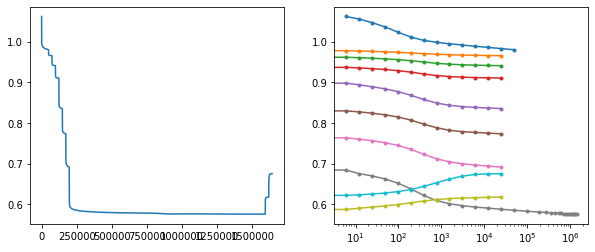

In [64]:
plt.figure(figsize=(10,4))          
plt.subplot(121)
plt.plot(oed['time_cum'],oed['void_ratio'])
plt.subplot(122)
for step in load_steps:
    plt.semilogx(oed[oed['load_step']==step]['time'],oed[oed['load_step']==step]['void_ratio'],'.-')

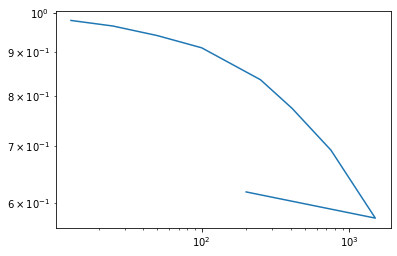

In [65]:
df1=oed[oed['time']==0]
plt.loglog(df1['load_start'],df1['void_ratio'])

### 1.1 Setting up load steps

In [66]:
load = LoadSteps()
for step in load_steps:
    load.add_load_step(np.max(oed[oed['load_step']==step]['time']),oed[oed['load_step']==step]['load_stop'].iloc[0])

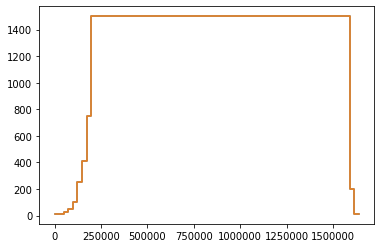

In [67]:
plt.plot(load.loaddf)
plt.plot(oed['time_cum'],oed['load_stop'])

### 1.2 Sampling for fit

In [68]:
def param_def():
    log_scale={}
    param=lmfit.Parameters()
    param.add('Cc',value=0.5,vary=True,min=0.1,max=0.8);                                                log_scale['Cc']=False
    param.add('Cr',value=0.05,vary=True,min=0.01, max=0.1);                                             log_scale['Cr']=False
    param.add('Cv',value=1/3600/24/365,vary=True,min=1/3600/24/365,max=20/3600/24/365);                 log_scale['Cv']=False
    param.add('sigmap',value=np.log10(50),vary=True,min=np.log10(1),max=np.log10(1000));                log_scale['sigmap']=True 
    return param,log_scale
def log_sample_creation(x_values,y_values,num_samples=20,min_val=1):
    xsample=10**np.linspace(np.log10(min_val),np.log10(np.max(x_values[:]*0.95)),num_samples) #sampling but not till the very end of the load step to avoid disturbance effects
    ysample=np.interp(xsample,x_values,y_values)
    return xsample,ysample

In [69]:
xsample={}; ysample={} 
time_start={};time_end={}
for i in load.load_steps[1:]:
    time_step=oed[oed['load_step']==load_steps[i-1]]['time']
    e_step = oed[oed['load_step']==load_steps[i-1]]['void_ratio']
    xsample[i],ysample[i]=log_sample_creation(time_step,e_step,num_samples=20,min_val=1)
    time_start[i]=load.start_time[i];time_end[i]=load.end_time[i]

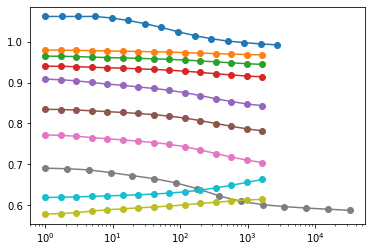

In [70]:
for i in load.load_steps[1:]:
    plt.semilogx(xsample[i][:15],ysample[i][:15],'o-')

## 2. Fitting model to a lab test

In [118]:
data_store='../save_files/'+'Parameter_fit_lab'
param,logscale=param_def()

#### 2.2.1 Standard fitting procedures in lmfit

In [122]:
two_way_drainage=True
maxfev=1000
for method in ['lfbgsb','differential_evolution']: 
    save_file[method]=pd.DataFrame()
    out = lmfit.minimize(lstsq_FDM_V, param, args=(xsample,ysample,time_start,time_end,load,method,e0,H),kws={'log_scale':logscale,'mode':'absolute','plotting':False,'lim_num':1000,'dtfactor':5000,'two_way_drainage':two_way_drainage},method=method,options={'maxfev':maxfev}) #,fit_kws={'maxfunevals':1}
    save_file_to_h5(save_file[method],data_store,method,dimension='Terzaghi',remarks='equal_weight') #_focused_loss
    print('')

lfbgsb  iteration:283  lstsq = 0.11914697849403023
differential_evolution  iteration:2411  lstsq = 0.07018973279611996


#### 2.2.2 Customised multiple local searches to a unique solution

In [147]:
import functions
reload(functions)
from functions import *

In [148]:
out=optim_minmaxrand(param,lstsq_FDM_V,load,xsample,ysample,e0,H,time_start,time_end,logscale,remark_1='Terzaghi',remarks='equal_weight',data_store=data_store,dtfactor=5000,two_way_drainage=two_way_drainage)

optim_minmaxrand  iteration:546  lstsq = 0.046986047652057064
optim_minmaxrand  iteration:703  lstsq = 0.15146787597201128
optim_minmaxrand  iteration:1120  lstsq = 0.046985941015872826
2
[0.04698594]; [0.04698605]; [0.15146788]
0.0005159464911509525

optim_minmaxrand  iteration:1491  lstsq = 0.046985614901329326
3
[0.04698561]; [0.04698594]; [0.04698605]
0.00024942715619774596



# 3. Load results

In [156]:
load_file,metadata=read_h5(data_store)

# 4. Plotting resulting fit

In [157]:
list(load_file)

['/Terzaghi-differential_evolution-equal_weight',
 '/Terzaghi-lfbgsb-equal_weight',
 '/Terzaghi-optim_minmaxrand-equal_weight']

In [158]:
k = '/Terzaghi-optim_minmaxrand-equal_weight'

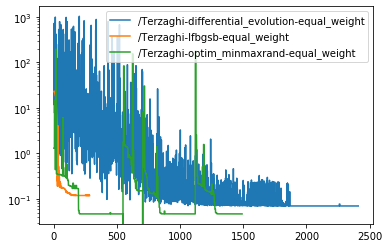

In [159]:
for k in load_file.keys():
    plt.semilogy(load_file[k]['lstsq'].values,label=k)
plt.legend()

In [160]:
pm={}
for p in list(param):
    if logscale[p]:
        pm[p]=10**load_file[k].iloc[-1][p]
    else:
        pm[p]=load_file[k].iloc[-1][p]
print([p+'='+str(pm[p]) for p in pm if param[p].vary])
%time time,Uavg,u,e,sigveff,sigveffavg,eavg,sigmav = FDM_V_implicit(pm['Cc'],pm['Cr'],pm['sigmap'],pm['Cv'],e0,H,load.loaddf,targettime=time_end[list(time_end)[-1]],dtfactor=5000)

['Cc=0.3450297704486319', 'Cr=0.0690271781728517', 'Cv=3.171019669196019e-08', 'sigmap=156.29034947099248']
CPU times: user 1.36 s, sys: 4.01 ms, total: 1.37 s
Wall time: 1.38 s


/home/thomasvergote/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Text(0, 0.5, 'Void ratio [-]')

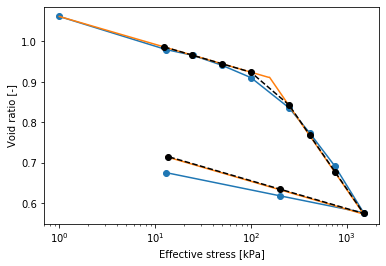

In [161]:
df1=oed[(oed['time']==0)|(oed['time_cum']==6)|(oed['time_cum']==np.max(oed['time_cum']))]
df1.loc[df1.index[0],'load_start']=1
df1.loc[df1.index[-1],'load_start']=df1.loc[df1.index[-1],'load_stop']
df1=df1.sort_values('time_cum')
plt.semilogx(df1['load_start'],df1['void_ratio'],'o-')
plt.plot(sigveff[10,:],e[10,:])
EOP=get_EOP(time,u,sigmav)
plt.plot([sigveffavg[i] for i in range(len(time)) if time[i] in EOP],[eavg[i] for i in range(len(time)) if time[i] in EOP],'ko--')
plt.xlabel('Effective stress [kPa]'); plt.ylabel('Void ratio [-]')


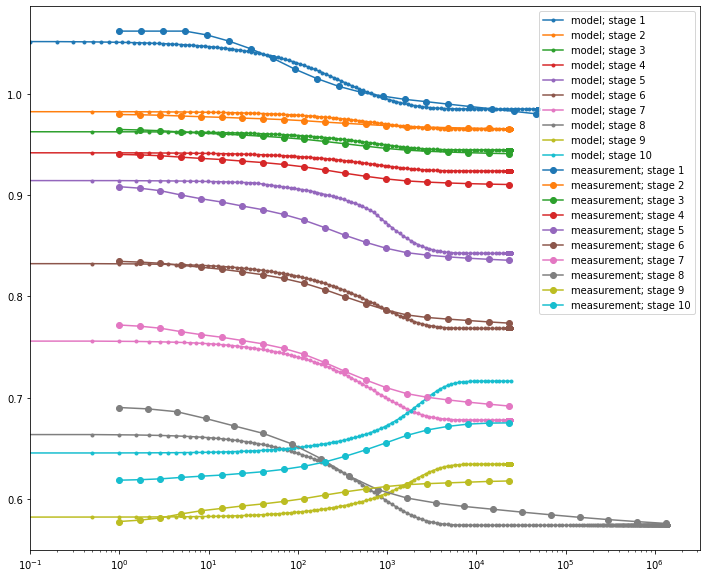

In [162]:
rel=0
plt.figure(figsize=(12,10))
for L in xsample.keys():
    time_new = time[(time>=time_start[L]) & (time<=time_end[L]-1)] -time[(time>=time_start[L]) & (time<=time_end[L]-1)] [0]
    e1 = eavg[(time>=time_start[L]) & (time<=time_end[L]-1)]-eavg[(time>=time_start[L])][0]*rel
    plt.plot(time_new,e1,'.-',label='model; stage '+str(L))
plt.gca().set_prop_cycle(None)
for L in xsample.keys():
    ysample[L]=ysample[L]-ysample[L][0]*rel
    plt.semilogx(xsample[L],ysample[L],'o-',label='measurement; stage '+str(L))
plt.xlim(0.1)
plt.legend();plt.show(); 